In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel('/content/Obidos.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18879 entries, 0 to 18878
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id_station     18879 non-null  int64         
 1   nom            18879 non-null  object        
 2   date           18879 non-null  datetime64[ns]
 3   valeur (m3/s)  18878 non-null  float64       
 4   origine        18878 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 737.6+ KB


In [4]:
df = df[['date', 'valeur (m3/s)']]
df = df.set_index('date')
df.sort_index(inplace=True)

In [5]:
df

,valeur (m3/s)
date,
1968-02-23 12:00:00,141400.0
1968-02-24 12:00:00,141800.0
1968-02-25 12:00:00,142700.0
1968-02-26 12:00:00,144300.0
1968-02-27 12:00:00,145000.0
...,...
2019-12-11 12:00:00,136400.0
2019-12-12 12:00:00,137100.0
2019-12-13 12:00:00,137700.0


In [6]:
print('Cantidad de datos faltantes:')
for column in df:
    nans = df[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de datos faltantes:
	Columna valeur (m3/s): 1


In [7]:
#Inteerpolación de los datos faltantes, que es solo q
for column in df.columns:
    df[column] = df[column].interpolate(method='linear')

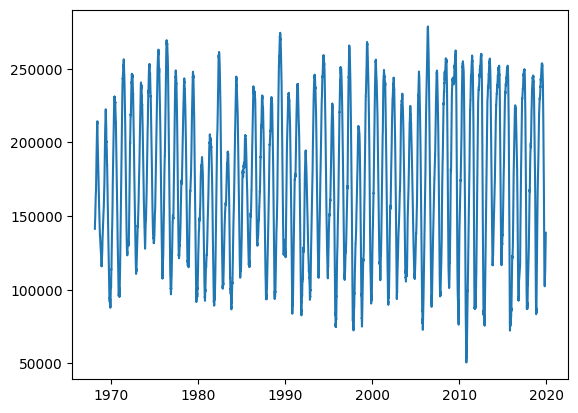

In [8]:
plt.plot(df)

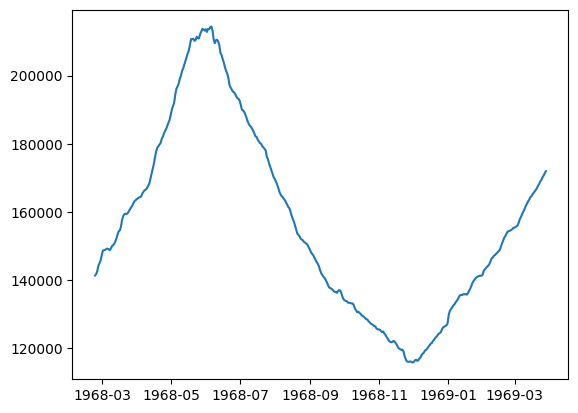

In [9]:
#Identificación del patrón de comportamiento para un año específico
plt.plot(df[:400])

In [10]:
df_time_diffs = df.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

86400.0      18877
3974400.0        1
Name: date, dtype: int64


In [11]:
#Fecha en la que hay una falta de registros de aproximadamente mes y medio
df_time_diffs[df_time_diffs == 3974400.0]

date
2017-01-01 12:00:00    3974400.0
Name: date, dtype: float64

In [12]:
#Llenamos los registros que no aparecían
df2 = df.asfreq(freq='D', method='bfill')

In [13]:
df_time_diffs = df2.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

86400.0    18923
Name: date, dtype: int64


In [14]:
#Se escalan las variables para evitar que el modelo se sesgue por las dimensiones de las variables
MM = MinMaxScaler()
df_Norm = pd.DataFrame(MM.fit_transform(df2))

In [15]:
df.describe()

,valeur (m3/s)
count,18879.000000
mean,175319.096615
std,51926.432070
min,50680.000000
25%,130700.000000
50%,175900.000000
75%,223100.000000
max,278700.000000


In [16]:
df2.describe()

,valeur (m3/s)
count,18924.000000
mean,175180.417724
std,51942.382325
min,50680.000000
25%,130400.000000
50%,175700.000000
75%,223000.000000
max,278700.000000


In [17]:
def particion(data, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):

    N = data.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = data[0:Ntrain]
    val = data[Ntrain:Ntrain+Nval]
    test = data[Ntrain+Nval:]

    return train, val, test

In [18]:
tr, vl, ts = particion(df_Norm)

In [19]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
long_entrada = 30    # Posteriormente afinaremos este hiperparámetro
long_salida = 1    # Modelo uni-step

def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+long_entrada,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [20]:
x_tr, y_tr = crear_dataset_supervisado(tr.values, long_entrada, long_salida)
x_vl, y_vl = crear_dataset_supervisado(vl.values, long_entrada, long_salida)
x_ts, y_ts = crear_dataset_supervisado(ts.values, long_entrada, long_salida)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (15108, 30, 1), y_tr: (15108, 1, 1)
Set de validación - x_vl: (1861, 30, 1), y_vl: (1861, 1, 1)
Set de prueba - x_ts: (1862, 30, 1), y_ts: (1862, 1, 1)


In [21]:
df_Norm

,0
0,0.397860
1,0.399614
2,0.403561
3,0.410578
4,0.413648
...,...
18919,0.375932
18920,0.379002
18921,0.381633
18922,0.382072


In [22]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr.shape[1], x_tr.shape[2]) # 30 (días) x 1 (feature)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(long_salida, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

def RMS(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = RMS,
)

# Entrenamiento
EPOCHS = 80 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
grafico = modelo.fit(
    x = x_tr,
    y = y_tr,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl, y_vl),
    verbose=2
)

Epoch 1/80
60/60 - 10s - loss: 0.3797 - val_loss: 0.1904 - 10s/epoch - 163ms/step
Epoch 2/80
60/60 - 8s - loss: 0.0619 - val_loss: 0.0563 - 8s/epoch - 131ms/step
Epoch 3/80
60/60 - 6s - loss: 0.0372 - val_loss: 0.0491 - 6s/epoch - 103ms/step
Epoch 4/80
60/60 - 7s - loss: 0.0328 - val_loss: 0.0450 - 7s/epoch - 121ms/step
Epoch 5/80
60/60 - 6s - loss: 0.0292 - val_loss: 0.0429 - 6s/epoch - 104ms/step
Epoch 6/80
60/60 - 7s - loss: 0.0259 - val_loss: 0.0334 - 7s/epoch - 120ms/step
Epoch 7/80
60/60 - 6s - loss: 0.0221 - val_loss: 0.0267 - 6s/epoch - 104ms/step
Epoch 8/80
60/60 - 7s - loss: 0.0179 - val_loss: 0.0249 - 7s/epoch - 122ms/step
Epoch 9/80
60/60 - 6s - loss: 0.0138 - val_loss: 0.0224 - 6s/epoch - 108ms/step
Epoch 10/80
60/60 - 8s - loss: 0.0111 - val_loss: 0.0120 - 8s/epoch - 134ms/step
Epoch 11/80
60/60 - 7s - loss: 0.0101 - val_loss: 0.0165 - 7s/epoch - 122ms/step
Epoch 12/80
60/60 - 6s - loss: 0.0100 - val_loss: 0.0124 - 6s/epoch - 103ms/step
Epoch 13/80
60/60 - 7s - loss: 0.01

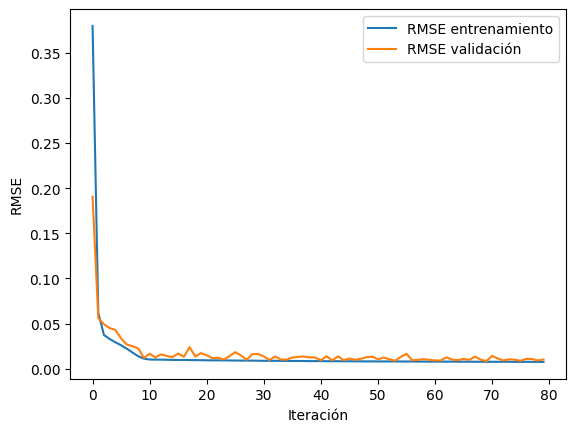

In [23]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(grafico.history['loss'],label='RMSE entrenamiento')
plt.plot(grafico.history['val_loss'],label='RMSE validación')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

In [24]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr, y=y_tr, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl, y=y_vl, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts, y=y_ts, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.009
  RMSE val:	 0.010
  RMSE test:	 0.010
